# Agent-based model of tumor growth 

This Notebook was written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/) and lives at [Github](https://github.com/petermchale/tumor). Follow [these instructions](http://jupyter.readthedocs.io/en/latest/install.html)
to execute the Notebook using Python. Otherwise, [view this Notebook](https://nbviewer.jupyter.org/github/petermchale/tumor/blob/master/demonstration.ipynb?flush_cache=true) (and its inline animations) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org). 

## Introduction

<span style="color:red">Some Motivation<span>

## Making the contents of the tumor package visible to the Notebook

In [1]:
import os
repository_directory = os.getcwd() 
package_directory = repository_directory + '/tumor_package'
print('package directory:\t' + package_directory)
import sys
print('Python searches these paths when asked to import a module:')
sys.path.append(package_directory)
for path in sys.path: 
    print(path)

package directory:	/Users/ccbs/Desktop/tumor/tumor_package
Python searches these paths when asked to import a module:

/Users/ccbs/anaconda/lib/python35.zip
/Users/ccbs/anaconda/lib/python3.5
/Users/ccbs/anaconda/lib/python3.5/plat-darwin
/Users/ccbs/anaconda/lib/python3.5/lib-dynload
/Users/ccbs/anaconda/lib/python3.5/site-packages
/Users/ccbs/anaconda/lib/python3.5/site-packages/Sphinx-1.4.1-py3.5.egg
/Users/ccbs/anaconda/lib/python3.5/site-packages/aeosa
/Users/ccbs/anaconda/lib/python3.5/site-packages/setuptools-23.0.0-py3.5.egg
/Users/ccbs/anaconda/lib/python3.5/site-packages/IPython/extensions
/Users/ccbs/.ipython
/Users/ccbs/Desktop/tumor/tumor_package


## Simulating tumor growth 

In [2]:
# Set up the code that will animate tumor growth

from read import read_into_dict
initialCondition = read_into_dict('data/initialCondition.in')
parameterValues = read_into_dict('data/parameterValues.in')

from animate import animate_tumor_growth_base
fig, anim = animate_tumor_growth_base(initialCondition, parameterValues, number_of_frames=40, random_seed=2)

To embed the matplotlib animation `anim` in the notebook, I follow [Louis Tiao's blog post](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/). This requires a recent version of [Matplotlib](http://matplotlib.org), and an animation writer called [ffmpeg](https://ffmpeg.org), which you can install by first installing [Homebrew](http://brew.sh) and then typing `brew install ffmpeg` in the `Terminal`.

In [3]:
# Check matplotlib and ffmpeg
import matplotlib as mpl
print('matplotlib version:\t' + mpl.__version__ + '\t (should be at least 1.5.1)')
from matplotlib import pyplot as plt
print('animation writer:\t' + plt.rcParams['animation.writer'] + '\t (should be ffmpeg)')

matplotlib version:	1.5.1	 (should be at least 1.5.1)
animation writer:	ffmpeg	 (should be ffmpeg)


In [4]:
# Simulate and visualize the tumor
from IPython.display import HTML
HTML(anim.to_html5_video())

In this movie, each disc represents a tumor cell. Color indicates whether the cell is in a dividing/replicating/cycling state (green) or a non-dividing/quiescent state (red). Time is measured in units of a cell cycle: the average time that elapses between a cell's birth and its division. 

You can see that the tumor grows when it is composed mainly of cycling cells early on, arrests its growth when it becomes composed mainly of quiescent cells, and finally starts to regress as cell death kicks in.

## The model

Having visualized the output of the model, let us now describe it in more detail. We suppose that the numbers of quiescent cells (Q-cells) influences the behavior of the cycling cells (C-cells). Specifically, at each cell cycle (on average) a C-cell chooses to divide or become quiescent with probabilities $p$ or $1-p$, respectively, that depend upon the number of Q-cells within the local neighborhood. 

<span style="color:red"> formulae<span>

## Statistical analysis of simulated tumor-growth data

In the movie shown above, negative feedback was chosen to have a spatial range that vastly exceeded the maximum size that the tumor could reach. Since negative feedback is initially responsible for arresting the growth of the tumor (i.e. before cell death kicks in), you might expect that reducing the spatial range of feedback would cause the tumor to expand exponentially. Simulations show, however, that negative feedback can arrest tumor growth even when the spatial range of feedback is smaller than the maximum tumor size. Fundamentally, this is possible because controlling the growth of the tumor early is more important than doing so late; in other words, errors have less impact when corrected early rather than late. 

Though changes in the spatial range of negative feedback don't necessarily abrogate growth control, they do lead to qualitative changes in the dynamics. To see this, generate an ensemble of tumor-growth time courses  by either running 

```python
from ensemble import generate_tumor_growth_trajectories_base
generate_tumor_growth_trajectories_base(initialCondition, parameterValues, number_realizations=1, random_seed=2, output_directory_name='data/')
```

in this Notebook; or by running 

```unix
cd data 
python ../tumor_package/ensemble.py
```

in `Terminal`.

Generating a large number of realizations of tumor growth takes a while. To speed up the execution of this Notebook, I will therefore use pre-existing data for long- and short-range negative feedback. Let's now read in these data and visually compare the simulated tumor-growth time courses.

In [5]:
# Read in data 

class Data(object): 
    
    def __init__(self, time_points, number_C_cells, number_Q_cells): 
    
        self.time_points = time_points
        self.number_C_cells = number_C_cells
        self.number_Q_cells = number_Q_cells
        self.total_number_cells = self.number_C_cells + self.number_Q_cells

def create_data_object_from_file(data_file_name):
    
    import numpy as np
    with np.load(data_file_name) as data_set:
        time_points = data_set['time_points']
        number_C_cells = data_set['number_C_cells']
        number_Q_cells = data_set['number_Q_cells']
    
    return Data(time_points, number_C_cells, number_Q_cells)

data_short = create_data_object_from_file('data/short_range_negative_feedback/tumor_time_courses.npz')
data_long = create_data_object_from_file('data/long_range_negative_feedback/tumor_time_courses.npz')

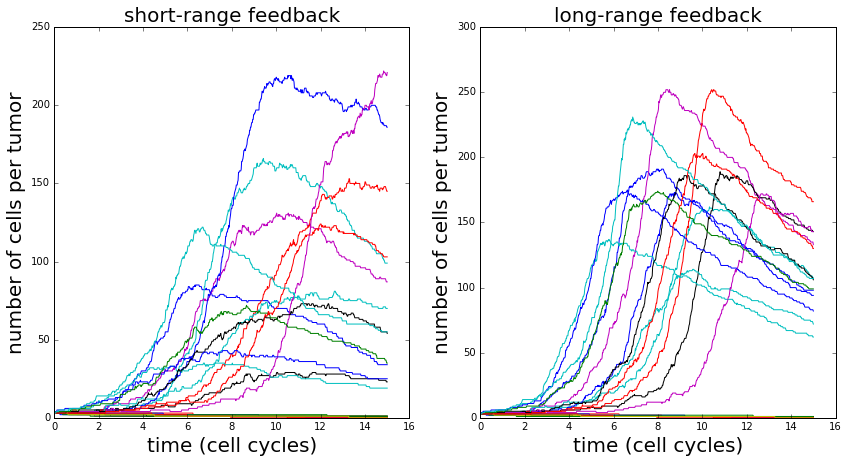

In [6]:
# Visually compare time courses for short- and long-range negative feedback

%matplotlib inline

number_subplot_rows = 1
number_subplot_columns = 2
fig = plt.figure(figsize=(14, 7), facecolor='w')

def plot_time_courses(data, axis_number, title):

    ax = fig.add_subplot(number_subplot_rows, number_subplot_columns, axis_number)
    ax.plot(data.time_points.T, data.total_number_cells.T, linewidth=1)
    fontsize = 20
    ax.set_xlabel('time (cell cycles)', fontsize=fontsize)
    ax.set_ylabel('number of cells per tumor', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    
def thin(data, step): 
        
    def thin_base(arr):
        return arr[1::step, :]
    
    return Data(thin_base(data.time_points), thin_base(data.number_C_cells), thin_base(data.number_Q_cells))
    
step = 4
plot_time_courses(thin(data_short, step) ,axis_number=1, title='short-range feedback')
plot_time_courses(thin(data_long, step) ,axis_number=2, title='long-range feedback')

    
#     index_at_which_to_plot_histogram = (np.abs(self.time_points[0, :] - time_at_which_to_plot_histogram)).argmin()
#     self.time_at_which_to_plot_histogram = self.time_points[0, index_at_which_to_plot_histogram]

#     self.number_C_cells_at_time_point = self.number_C_cells[:, index_at_which_to_plot_histogram]
#     self.number_Q_cells_at_time_point = self.number_Q_cells[:, index_at_which_to_plot_histogram]
#     self.total_number_cells_at_time_point = self.total_number_cells[:, index_at_which_to_plot_histogram]

# time_at_which_to_plot_histogram = 10
# step = 4




Each color represents a single realization of a growing tumor. Note that the inherent stochasticity in the model leads to widely varying tumor-growth trajectories (left panel). Increasing the spatial range of the negative feedback averages out a portion of this stochasticity making the trajectories look more uniform (right panel).